# Tutorial: Protein Folding with Quantum Approximate Optimization Algorithm (QAOA)

by: Hanna Linn, WACQT Chalmers
GitHub repository with all dependencies: https://github.com/PotatisMaster/TutorialQAOAProteinFolding

This tutorial walks through performing protein folding of the hydrophobic-polar lattice model in two dimensions using Quantum Approximate Optimization Algorithm (QAOA). 

## Overview
In this tutorial, we start by defining our amino acid sequence of what we want to fold together with a lattice grid on which we want to fold our sequence. We then define an energy function that, given a folding (placement) of the sequence on the grid, gives us a potential. The goal is to find the folding with the lowest potential, called the native state of the amino acid sequence. We usually have more than one native state, all with the same energy. The process can be defined as an optimisation:

Given an energy function, $E(x)$, and a folding $x$:
\begin{equation}
\begin{array}{ll@{}ll}
\text{minimise}  & E(x) &\\
\text{subject to}& x \in F, & &
\end{array}
\end{equation}
where $F$ is the feasible solution set of the problem, i.e., all $ x \in F$ translates to physically possible protein folding.

For details of the energy function used in this tutorial, please see Irbäck et al. 2022: 
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013

Here, we aim to do the optimisation with the Quantum Approximate Optimization Algorithm (QAOA) using Pennylane https://pennylane.ai/qml/demos/tutorial_qaoa_intro

In [1]:
# These two lines make sure that the 
%load_ext autoreload
%autoreload 2

import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hamiltonian import protein_folding_hamiltonian
from CoordinateBased_HPLatticeClass import CoordinateBased_HPLattice
from utils import *

## Protein model

The HP-lattice model in two dimensions has two types of beads: H for hydrophobic and P for polar. We can make an instance of the model by defining the sequence with 1 for H and 0 for P and a lattice grid size.

The model is described in detail in Sec II. "Methods" part B "Binary quadratic model for HP lattice proteins – QUBO encoding" in Irbäck et al. 2022.
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043013

The energy function can be defined as:
\begin{equation}
    E = E_{HP} + \sum_{i=1}^3 \lambda_i E_i,
\end{equation}
where $E_{HP}$ is the energy term for the HP model and the terms $E_1$, $E_2$ and $E_3$ are constraint energies with the penalty vector $\lambda_i,\ i=1,2,3$ controlling the strength of the constraints.

\begin{equation}
    E_{HP} = - \sum_{|f-f'|>1}C(h_f, h_f') \sum_{(s,s')}\sigma_s^f\sigma_{s'}^{f'}
\end{equation}

\begin{equation}
    C(h_f,h_{f'}) =     \begin{cases}
      1, & \text{if } h_f = h_{f'} = \text{H}, \\
      0, & \text{otherwise}.
    \end{cases} 
\end{equation}

\begin{equation}
    E_1 = \sum_f \left(\sum_s\sigma_s^f-1\right)^2 + \left\{ \text{same for odd parity} \right\}
\end{equation}

\begin{equation}
    E_2 = \frac{1}{2} \sum_{f_1 \not = f_2} \sum_s \sigma_s^f\sum_{||s'-s||>1} \sigma_{s'}^{f+1} + \left\{ \text{same for odd parity} \right\}
\end{equation}

\begin{equation}
\begin{split}
    E_3 =& \sum_{1 \leq f<N} \sum_s \sigma_s^f \sum_{||s'-s||>1} \sigma_{s'}^{f+1} \\
    & + \left\{ \text{same with odd/even parity interchanged} \right\},
\end{split}
\end{equation}
where $\sigma_s^f$ to describe the location of the even beads. The index $f$ is the beads and $s$ is the sites (' are the odd beads and sites). The $\sigma_s^f=1$ if bead $f$ is located on site $s$, and $\sigma_s^f=0$ otherwise, same for odds. The sites and beads are divided into odds and even to reduce the number of bits required from the number of amino acids times the area of the grid to half.

The terms in the energy function can be clumped together to one-body energy $O_i$, and two-body interaction $T_{ij}$, the pairwise interaction potentials.
The energy function to optimize can be written as
\begin{equation}
    E(x) = \underbrace{\sum^N_{i=1} O_i x_i}_\text{one-body} + \underbrace{\sum^{N-1}_{i=1}\sum^N_{j=i+1} T_{ij}x_ix_j}_\text{two-body},
\end{equation}
where $x_i$ is a bitstring representing the folding on the lattice. $x_1$ is the choise, 1 for yes and 0 for no, of putting the first amino acid on position (0,0) on the grid.

In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 3
L2 = 2

lambda_vector = (2.1, 2.4, 3.0) # see Fig.2 in Irbäck et al.

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)
print()

print('What all bits are, on the format ((x,y)-coordninate on the grid, which index of the sequence): ', protein.get_bit_names(), '\n')
print('The number of bits needed to encode one folding: ', protein.num_bits, '\n')
print('The quotient of size of feasible set compared to the total solution set:', protein.get_feasible_percentage(), '\n')


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  4.2  0.   0.   3.   2.4  0.   0.  -1.  -1.   0. ]
 [ 4.2  0.   4.2  0.   0.   0.   0.   2.4  0.  -1.  -1.  -1. ]
 [ 4.2  4.2  0.   3.   0.   0.   0.   0.   2.4  0.  -1.  -1. ]
 [ 0.   0.   3.   0.   4.2  4.2  0.   0.   3.   2.4  0.   0. ]
 [ 0.   0.   0.   4.2  0.   4.2  0.   0.   0.   0.   2.4  0. ]
 [ 3.   0.   0.   4.2  4.2  0.   3.   0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   3.   0.   4.2  4.2  0.   0.   3. ]
 [ 0.   2.4  0.   0.   0.   0.   4.2  0.   4.2  0.   0.   0. ]
 [ 0.   0.   2.4  3.   0.   0.   4.2  4.2  0.   3.   0.   0. ]
 [-1.  -1.   0.   2.4  0.   0.   0.   0.   3.   0.   4.2  4.2]
 [-1.  -1.  -1.   0.   2.4  0.   0.   0.   0.   4.2  0.   4.2]
 [ 0.  -1.  -1.   0.   0.   2.4  3.   0.   0.   4.2  4.2  0. ]]

What all bits are, on the format ((x,y)-coordninate on the grid, which index of the sequence):  [((0, 0), 0), ((1, 1), 0), ((2, 0), 0), ((0, 1), 1), ((1, 0), 1), 

First solution in the feasible solution set: 
[((0, 0), 0), ((0, 1), 1), ((1, 1), 2), ((1, 0), 3)]


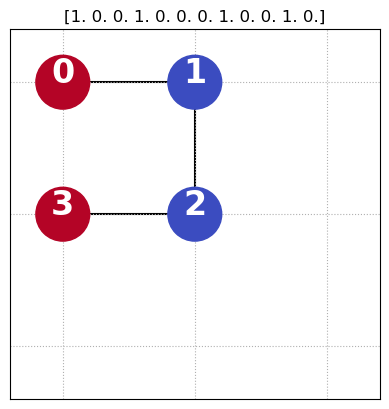

In [3]:
# Draw the protein
print('First solution in the feasible solution set: ')
x = [True if x > 0 else False for x in feasible_set[0]]
y = protein.get_bit_names()
print([b for a, b in zip(x, y) if a])

protein.viz_lattice(feasible_set[0])

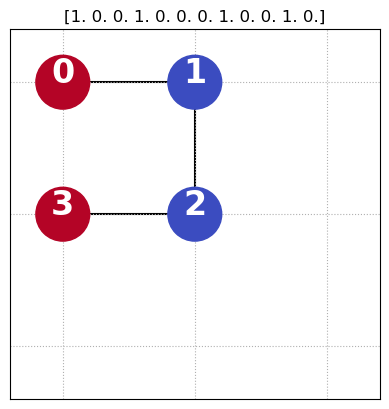

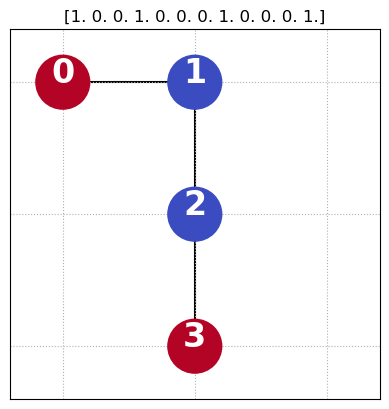

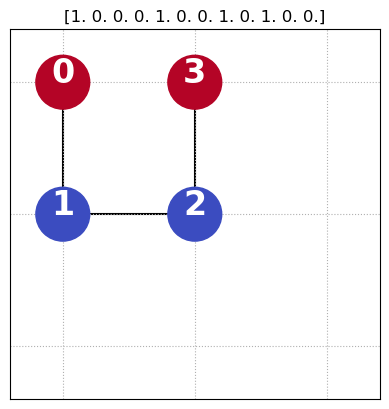

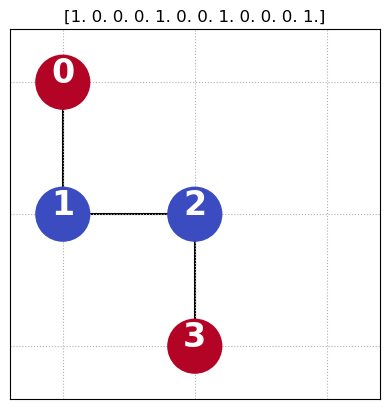

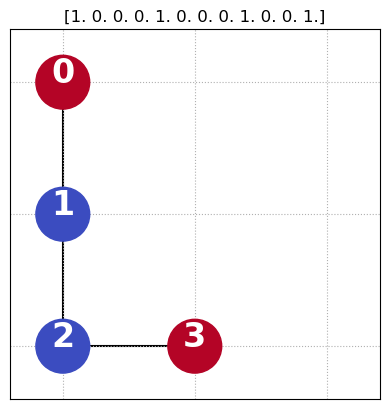

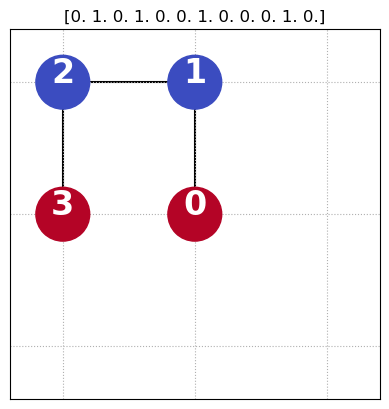

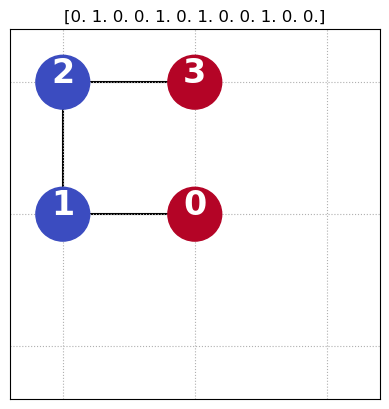

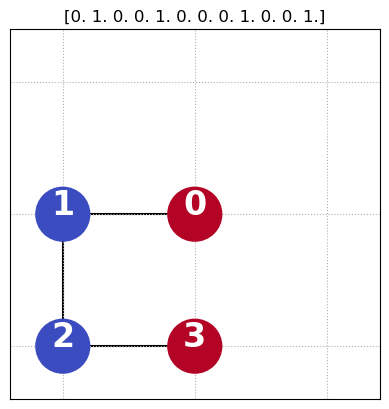

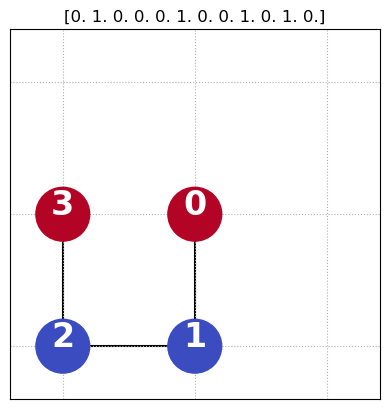

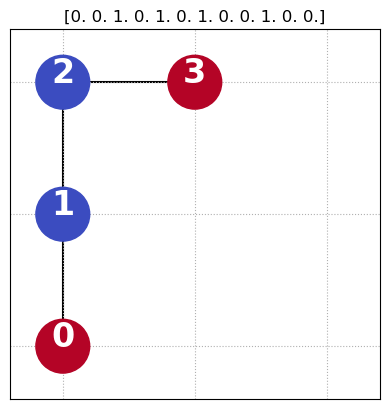

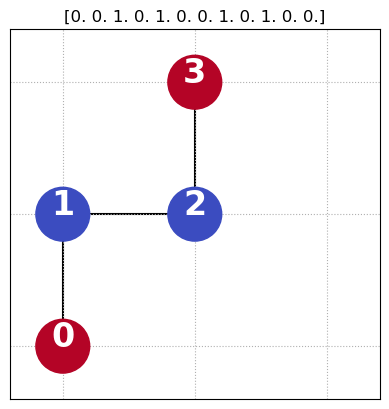

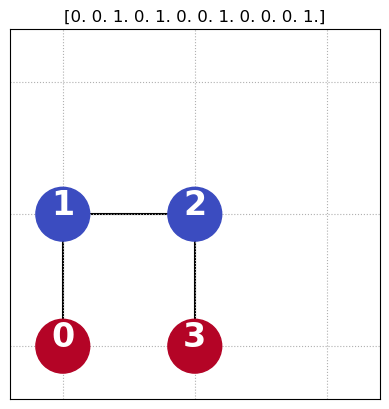

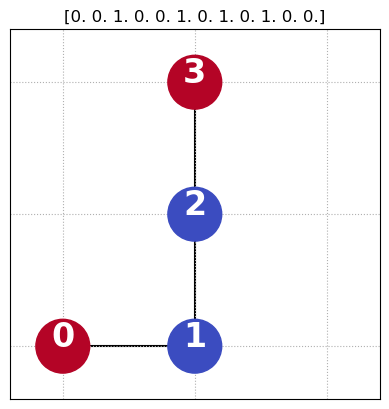

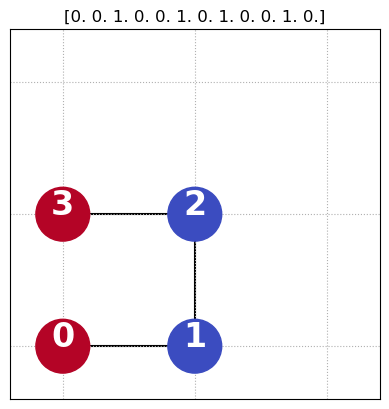

In [4]:
# Draw all proteins in feasible solution set
for j,i in enumerate(feasible_set):
    plt.figure(j)
    protein.viz_lattice(i)

## Quantum Approximate Optimization Algorithm (QAOA)
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
In QAOA, the circuit is done in a sequence of depth $p$:
\begin{equation}
    \begin{split}
        \ket{\psi_p(\gamma, \beta)} = & e^{-i\beta_p H_{mixer}} e^{-i\gamma_p H_{\text{cost}}}\\
        &... e^{-i\beta_1 H_{mixer}} e^{-i\gamma_1 H_{\text{cost}}} \ket{\psi_{\text{init.}}},
    \end{split}
\end{equation}
where $\gamma$ and $\beta$ are vectors of parameters to optimise by a classical computer so that the probability of measuring the optimal state is high.

The function to optimise is often the expectation value
\begin{equation}
    C_{\text{obj.}} = \bra{\psi_p(\gamma, \beta)}H_{cost}\ket{\psi_p(\gamma, \beta)},
\end{equation}
where $C_{\text{obj.}}$ is the energy function in our case.
If we get the lowest expectation value, we should get the answer with the lowest energy.

For details on how to run QAOA in Pennylane: https://pennylane.ai/qml/demos/tutorial_qaoa_intro

### Protein instance into cost Hamiltonian

Here, we create a cost Hamiltonian from the protein by translating the binary variables $x_i=\{0,1\}$ to spin $q_i=\{1,-1\}$ for the qubits. We end up with a problem on the form of an Ising Hamiltonian:

\begin{equation}
    H_{\text{cost}} = \sum_i h_i \sigma_i^z + \sum_{ij} J_{ij} \sigma_i^z \sigma_j^z,
\end{equation}
where $h_i$ are the field constants applied to qubit $i$ translated from the one-body energies, $J_{ij}$ are the two-body interaction constants between qubit $i$ and $j$ translated from the two-body energies and $\sigma^z$ is the Pauli operator in the $z$-direction.

In [5]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits) # naming the qubits
print('H_cost:\n' + str(H_cost))

H_cost:
  (-3.1500000000000004) [Z6]
+ (-3.1500000000000004) [Z8]
+ (-3.15) [Z3]
+ (-3.15) [Z5]
+ (-1.9) [Z9]
+ (-1.9) [Z11]
+ (-1.9) [Z0]
+ (-1.9) [Z2]
+ (-1.65) [Z7]
+ (-1.65) [Z4]
+ (-0.8999999999999999) [Z10]
+ (-0.8999999999999999) [Z1]
+ (-0.25) [Z0 Z9]
+ (-0.25) [Z0 Z10]
+ (-0.25) [Z1 Z9]
+ (-0.25) [Z1 Z10]
+ (-0.25) [Z1 Z11]
+ (-0.25) [Z2 Z10]
+ (-0.25) [Z2 Z11]
+ (0.0) [Z0 Z3]
+ (0.0) [Z0 Z4]
+ (0.0) [Z0 Z7]
+ (0.0) [Z0 Z8]
+ (0.0) [Z0 Z11]
+ (0.0) [Z1 Z3]
+ (0.0) [Z1 Z4]
+ (0.0) [Z1 Z5]
+ (0.0) [Z1 Z6]
+ (0.0) [Z1 Z8]
+ (0.0) [Z2 Z4]
+ (0.0) [Z2 Z5]
+ (0.0) [Z2 Z6]
+ (0.0) [Z2 Z7]
+ (0.0) [Z2 Z9]
+ (0.0) [Z3 Z6]
+ (0.0) [Z3 Z7]
+ (0.0) [Z3 Z10]
+ (0.0) [Z3 Z11]
+ (0.0) [Z4 Z6]
+ (0.0) [Z4 Z7]
+ (0.0) [Z4 Z8]
+ (0.0) [Z4 Z9]
+ (0.0) [Z4 Z11]
+ (0.0) [Z5 Z7]
+ (0.0) [Z5 Z8]
+ (0.0) [Z5 Z9]
+ (0.0) [Z5 Z10]
+ (0.0) [Z6 Z9]
+ (0.0) [Z6 Z10]
+ (0.0) [Z7 Z9]
+ (0.0) [Z7 Z10]
+ (0.0) [Z7 Z11]
+ (0.0) [Z8 Z10]
+ (0.0) [Z8 Z11]
+ (0.6) [Z0 Z6]
+ (0.6) [Z1 Z7]
+ (0.6) [Z2 Z8]
+ (0.6) [

### Ground state of the cost Hamiltonian
The native states of the protein are the ground states of the cost Hamiltonian. We need it to benchmark our algorithm's performance.

In [6]:
ground_energy, ground_states_index = get_ground_states_i(feasible_set, H_cost) # get the ground states

# This function is cheating! It is an extensive search through all solutions to find the one with the lowest energy.
# But we use it for benchmarking our algorithm on small problem instances.
print('Ground energy: ', ground_energy)

Ground energy:  -15.75


### We also need a mixer Hamiltonian for our QAOA

Pennylane has a command to get a simple X-mixer:
\begin{equation}
    H_{\text{mixer}} = \sum_i \sigma_i^x.
\end{equation}
where $\sigma^x$ is the Pauli operator in the $x$-direction.

In [7]:
H_mixer = qaoa.x_mixer(qubits)
print('H_mixer:\n' + str(H_mixer))

H_mixer:
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]
+ (1) [X8]
+ (1) [X9]
+ (1) [X10]
+ (1) [X11]


### Using Pennylane to build the QAOA circuit


In [8]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1]) # Repeats our layer p=len(params[0]) times.

# If we add a expectation value we get a cost function for average cost of the cost Hamiltonian for given parameters
@qml.qnode(dev)
def average_cost(params):
    circuit(params)
    return qml.expval(H_cost)

# Let's test it! Only one layer.
zero_parameters = np.array([[0],[0]]) # Gamma and Beta both set to 0.
half_parameters = np.array([[0.5],[0.5]])  # Gamma and Beta both set to 0.5.

#print('Average cost with gamma=0 and beta=0:\n', average_cost(zero_parameters))
print('Average cost with gamma=0.5 and beta=0.5:\n', average_cost(half_parameters))

# Draw our circuit
print()
print(qml.draw(average_cost, expansion_strategy = 'device')(zero_parameters))

Average cost with gamma=0.5 and beta=0.5:
 1.142734828865597

 0: ──H─╭RZZ(0.00)─╭RZZ(0.00)──RZ(-0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)─╭RZZ(0.00)
 1: ──H─╰RZZ(0.00)─│─────────────────────│──────────│──────────│──────────│──────────│─────────
 2: ──H────────────╰RZZ(0.00)────────────│──────────│──────────│──────────│──────────│─────────
 3: ──H──RZ(-0.00)───────────────────────╰RZZ(0.00)─│──────────│──────────│──────────│─────────
 4: ──H─────────────────────────────────────────────╰RZZ(0.00)─│──────────│──────────│─────────
 5: ──H──RZ(-0.00)─────────────────────────────────────────────╰RZZ(0.00)─│──────────│─────────
 6: ──H──RZ(-0.00)────────────────────────────────────────────────────────╰RZZ(0.00)─│─────────
 7: ──H──RZ(-0.00)───────────────────────────────────────────────────────────────────╰RZZ(0.00)
 8: ──H──RZ(-0.00)─────────────────────────────────────────────────────────────────────────────
 9: ──H──RZ(-0.00)────────────────────────────────────────────────────────

## Optimisation of the circuit parameters with a gradient descent

We walk in parameter space to find the best parameters to get a high probability for the low energy states.

In [9]:
# Define which optimiser we want to use, AdamOptimizer() is another option
optimiser = qml.GradientDescentOptimizer()

# How many steps are we taking
steps = 20 

# Naive initial parameters
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)

# Number of layers in our circuit
p = 2

# Vectors for saving the information
cost_vector = np.zeros(steps)
cost_vector[0] = average_cost(initial_params)
params_vector = np.zeros((steps, 2, p))

# Loop for performing the optimisation
params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(average_cost, params)
    cost_vector[i] = cost_

# How did we do?
best_params_optimisation = params
print('Optimal parameters after gradient descent:\n', best_params_optimisation)
print('\nAverage cost for the best parameters:', average_cost(best_params_optimisation))
print('Compared to the ground energy: ', ground_energy)

Optimal parameters after gradient descent:
 [[0.58036313 0.20126803]
 [0.40120566 0.48723116]]

Average cost for the best parameters: -1.4518091105793292
Compared to the ground energy:  -15.75


/tmp/ipykernel_15952/2123675139.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0.5, 1.0, 'Optimisation of $\\gamma$ and $\\beta$')

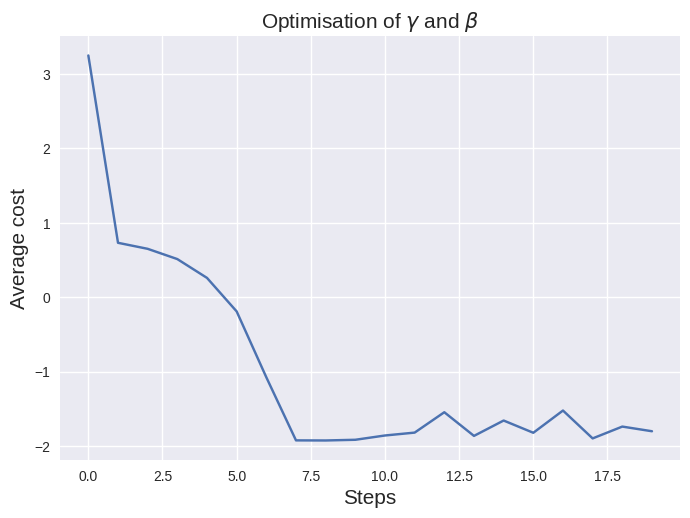

In [15]:
# Let's plot that
plt.style.use("seaborn")
plt.plot(cost_vector)
plt.xlabel('Steps', fontsize = 15)
plt.ylabel('Average cost', fontsize = 15)
plt.title(r'Optimisation of $\gamma$ and $\beta$', fontsize = 15)

### Evaluation of optimisation of cirquit parameters

We can see that the average cost of the circuit is lower than for the initial parameters. However, what does that mean for our protein? We want to ensure the probability to find the best fold is as high as possible.

Success probability or Overlap with solution:
\begin{equation}
    SP(\gamma, \beta) = |\braket{x_{best}}{\gamma, \beta}|^2
\end{equation}
which is the probability of measuring the solution given the parameters $\gamma, \beta$.

In [11]:
# A function for obtaining the probability of measuring the different foldings
# in the end of the circuit given a set of parameters
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires = qubits)


probs = probability_circuit(best_params_optimisation)
print('Success probability: ', np.sum(probs[ground_states_index]))

Success probability:  0.002879248552801237


<Figure size 800x550 with 0 Axes>

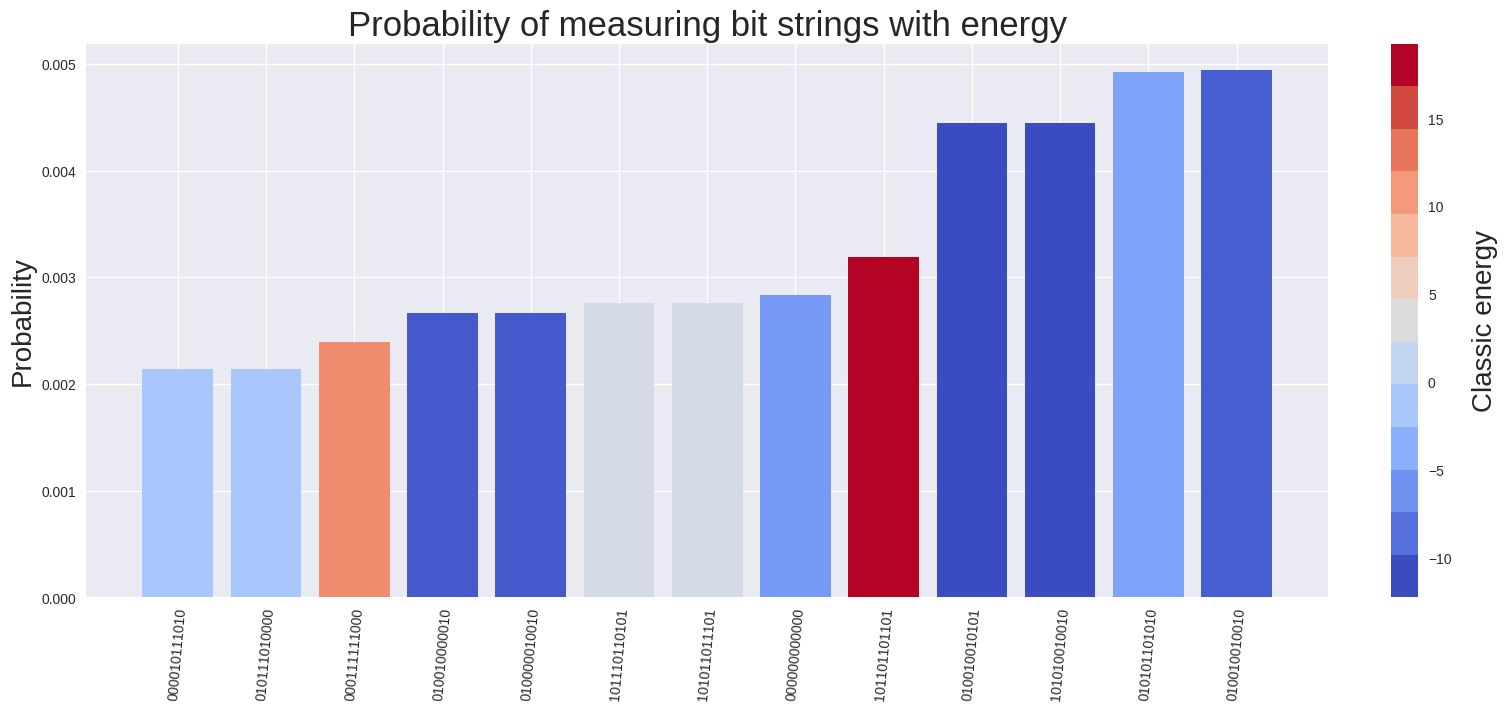

In [12]:
# Plot all solutions with a probability over a threshhold (to not over crowd the graph)
# The color of the graph is the classical energy of the solution/fold.
# A ground state will have a green label.

# If the there are no solutions with a probability over the threshhold we don't get a graph.
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index, threshhold = 0.002) # plot probability over bitstrings

Only one or two layers of the circuit will not perform very good.

# Here follows a different ways to get a better success probability

You can choose to continue tweeking above code to give better answers or to explore other suggestions for optimisation.

## Changing to a smarter mixer Hamiltonian

We can put one constraint in the mixer part of the QAOA algorithm.
See Hadfield et al. 2019: https://www.mdpi.com/1999-4893/12/2/34


The XY-mixer smarter mixer that uses the clusters of the positions on the grids deleting one constraint, by keeping the Hamming distance of the clusters.

\begin{equation}
    H_{XY-mixer} = \frac{1}{2} \sum_{i,j \in E(G)} (\sigma^x_i \sigma^x_j + \sigma^y_i \sigma^y_j),
\end{equation}

where the sum is over the edges in the graph $G$.

In [13]:
# Here is documentation https://docs.pennylane.ai/en/stable/code/api/pennylane.qaoa.mixers.xy_mixer.html
# protein.Dn is the graph you need

## Optimisation of the circuit parameters with grid search
 
Try all the parameters and save the best one. Not a great way to find the best parameters, but if we get them for p=1, then we may interpolate to a good initial guess for higher p.


/home/hannlinn/miniconda3/envs/tutorialproteinenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


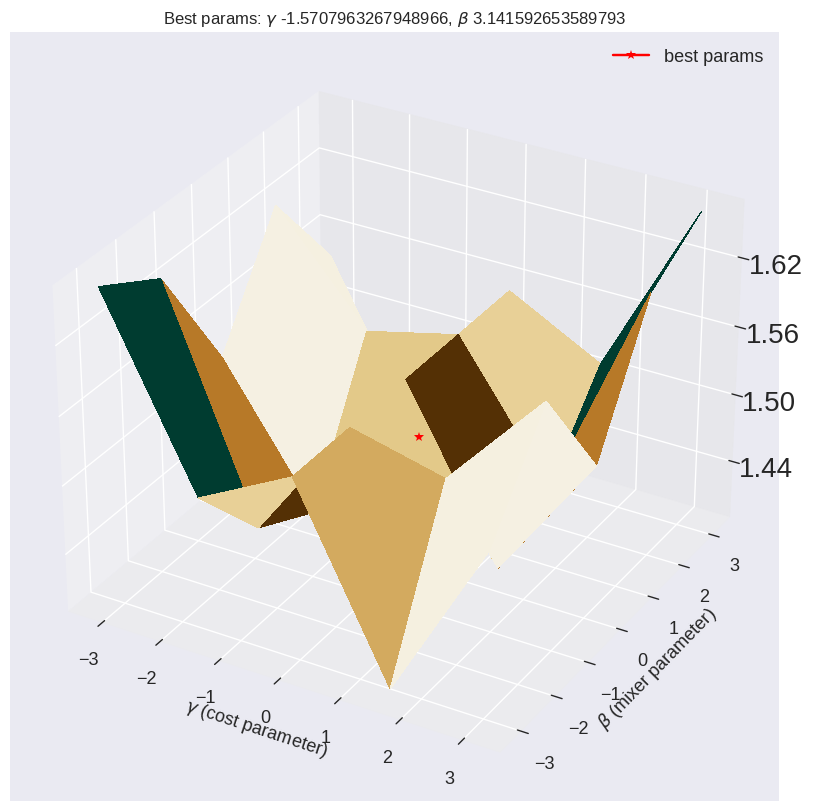

In [14]:
# Grid search
p = 1

start_gamma = -np.pi
stop_gamma = np.pi
num_points_gamma = 5 # the more points the better answer, but the longer the wait

start_beta = -np.pi
stop_beta = np.pi
num_points_beta = 5 # the more points the better answer, but the longer the wait

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

grid_search_params, Z, i = grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					average_cost,
					above = False,
					save = False)

In [ ]:
# More plotting, from above

X, Y, _= get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
                
plot_grid_search(X,
					Y,
					Z,
					i,
					above = True,
					name = '',
					save = False,
                fontsize = 20)

In [ ]:
# Is the grid search better?
probs = probability_circuit(grid_search_params)

plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_index)

print('Success probability of grid search: ', np.sum(probs[ground_states_index]))

### Interpolate parameters

For more details see Appendix B part 1. "Interpolation-based strategy" Lukin et al. 2020: https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.021067

In [ ]:
# Interpolate parameters to get next parameters to optimise over

interpolated_params = interpolate_params(grid_search_params, save = False, plot = False, only_last=False)

probs = probability_circuit(interpolated_params)
print('Success probability of interpolated annealing parameters: ', np.sum(probs[ground_states_index]))

# You can also interpolate from an optimisation run.

In [ ]:
# Grid search for p=2.
# Takes a long time so this cell may be skipped.

# Will build a 4-dimensional vector and go though all values getting the heurustic functions result.
# Then return the best parameters [0], and the tensor with the values [1].
params_p2 = vec_grid_search_p2(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 50, # keep in mind that a value over 10 will take forever
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 50, # keep in mind that a value over 10 will take forever
						heuristic = average_cost,
						vmap = False)[0]

probs = probability_circuit(params_p2)
print('Success probability of grid search p=2: ', np.sum(probs[ground_states_index]))


In [ ]:
# Interpolate from best parameters for p=2 to p=3.

params_p3 = interpolate_params(params_p2, save = False, plot = False, only_last=False)

probs = probability_circuit(params_p3)
print('Success probability of grid search p=3: ', np.sum(probs[ground_states_index]))



## Optimisation of the circuit parameters with quantum annealing initialisation

We can warm start the search for the best parameters by taking inspiration from quantum annealing.
Read more here: https://quantum-journal.org/papers/q-2021-07-01-491/

In [ ]:
annealing_params = get_annealing_params(annealing_time=2, 
                                        p=10, 
                                        linear = True, 
                                        cosine = False,
                                        sine = False,
                                        save = False,
                                        plot = False)
plt.figure(10)

probs = probability_circuit(annealing_params)

print('Success probability of annealing parameters: ', np.sum(probs[ground_states_i]))
#plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings

In [ ]:
# Is the annealing parameters better better?
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i, threshhold = 0.01)


## JAX and JIT
Read more here: https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

In [ ]:
# Use JAX and JIT packages to speed up the process. Calls for extensive installations.
# JIT is just-in-time compilation and will only work with small instances. If the number of qubits is 18 or more then the allocation of memory will complain.
# JAX work the fastest on a GPU, but still faster using vmap on the CPU.

# In order to run the just in time compilation and JAX, we need another qnode device.
# This wrapper function will do the job.
def jax_average_cost(params):
    '''
    Cost function with average cost of the state as metric.
    Jax version to be used with batches.
    '''
    #@jit
    @qml.qnode(dev, interface = 'jax')
    def _average_cost(params):
        circuit(params)
        return qml.expval(H_cost)
    return _average_cost(params)


params_p2 = vec_grid_search_p2(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 20, # keep in mind that a value over 10 will take forever
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 20,
						heuristic= jax_average_cost,
						vmap = True)[0]

probs = probability_circuit(params_p2)
print('Success probability of grid search p=2: ', np.sum(probs[ground_states_i]))

In [ ]:
# JAX for p=1.

grid_search_params, Z, i = grid_search(start_gamma = -np.pi,
						stop_gamma = np.pi,
						num_points_gamma = 500, # keep in mind that a value over 10 will take forever
						start_beta = -np.pi,
						stop_beta = np.pi,
						num_points_beta = 500,
						heuristic= jax_average_cost,
						vmap = True,
                        above = True,
                        save = True)
print(grid_search_params)
